# Tutorial: Using the SlimStampen Python code
## User Models 2020/2021

### Introduction

This notebook contains a basic demonstration of the functionality of the provided code to get you started.

***Tip:*** take a look at the code in `slimstampen/spacingmodel.py` to see how it works under the hood.

The provided code is compatible with Python 2.7 or newer (we recommend using an up-to-date version of Python 3).

If you have any questions, please ask for help!

### Importing the code

Download the `slimstampen` directory into your working directory.
You can then import the SlimStampen code into your own Python script as follows:

In [1]:
from slimstampen.spacingmodel import SpacingModel, Fact, Response

 ### Creating a model and registering facts

The `SpacingModel` class contains all the SlimStampen functionality you need to build a working system.

It implements the basic spacing model as shown in the figure below (from Sense et al., 2016).

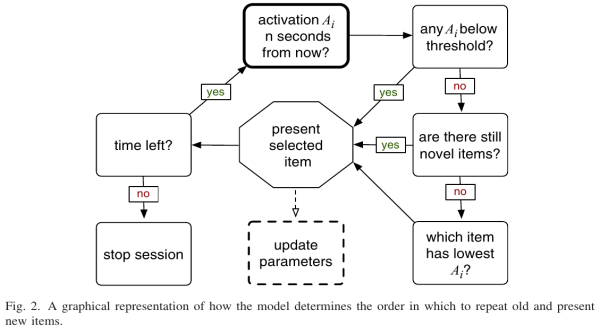

In [2]:
m = SpacingModel()

We can now register the facts that we want our users to learn.

The `Fact` class lets us define facts with a unique identifier, the question (i.e., what you show on the screen), and the answer (i.e., the response you expect from the user).

Here we're creating some English-French translation facts and adding them to the model:

In [3]:
fact1 = Fact(fact_id = 1, question = "hello", answer = "bonjour")
fact2 = Fact(2, "dog", "chien")
fact3 = Fact(3, "cat", "chat")
fact4 = Fact(4, "computer", "ordinateur")

m.add_fact(fact1)
m.add_fact(fact2)
m.add_fact(fact3)
m.add_fact(fact4)

In [4]:
m.facts

[Fact(fact_id=1, question='hello', answer='bonjour'),
 Fact(fact_id=2, question='dog', answer='chien'),
 Fact(fact_id=3, question='cat', answer='chat'),
 Fact(fact_id=4, question='computer', answer='ordinateur')]

### Asking for the next fact to study

Throughout the learning session we can repeatedly ask the model for the next fact to study using the `get_next_fact()` method. This method takes one argument: the time (in milliseconds) since the start of the learning session.

The method will return the fact that needs to be repeated most urgently at the current time (i.e., the one that is most likely to be forgotten).
If all facts that have been studied so far are "safe" for now, it returns a new fact to study instead.

Along with the fact itself, the method also returns a boolean indicating whether the returned fact is new (`True`) or whether it has been presented before (`False`).
We can use this information to change how the fact is presented to the user (e.g., by showing the answer when the fact has not been shown before). 

In [5]:
next_fact, new = m.get_next_fact(current_time = 34000)
next_fact, new

(Fact(fact_id=1, question='hello', answer='bonjour'), True)

### Logging the user's response

Once our system has presented the fact and obtained a response from the user, the response can be logged in the model.

By using a `Response` object, we can specify to which fact the user responded, at what time the presentation of the fact started (in milliseconds since the task onset), what the response time was (in milliseconds), and whether the response was correct.

In [6]:
resp = Response(fact = next_fact, start_time = 34029, rt = 2207, correct = True)

m.register_response(resp)

Check that the response has been logged:

In [7]:
m.responses

[Response(fact=Fact(fact_id=1, question='hello', answer='bonjour'), start_time=34029, rt=2207, correct=True)]

### Asking for more facts

When it's time to present the next trial, ask for another fact. With default parameter settings, the model chooses to immediately reinforce the fact that was just introduced, because it is likely to be forgotten otherwise. Note that this fact is now no longer marked as 'new'.

In [8]:
next_fact, new = m.get_next_fact(current_time = 38000)
next_fact, new

(Fact(fact_id=1, question='hello', answer='bonjour'), False)

Behind the scenes, the `get_next_fact` method has checked the expected activation of all facts slightly in the future (by default the model looks ahead 15 seconds). Since the activation of the first fact is predicted to be lower than the threshold of -0.8, it is selected for repetition. Note that facts that have not yet been studied have an activation of $-\infty$. 

In [9]:
for f in m.facts:
    print(f, m.calculate_activation(38000 + m.LOOKAHEAD_TIME, f))

Fact(fact_id=1, question='hello', answer='bonjour') -0.8828734492111224
Fact(fact_id=2, question='dog', answer='chien') -inf
Fact(fact_id=3, question='cat', answer='chat') -inf
Fact(fact_id=4, question='computer', answer='ordinateur') -inf


Let's say this fact is again presented to the user and a correct response is made.

In [10]:
resp = Response(fact = next_fact, start_time = 38007, rt = 1890, correct = True)

m.register_response(resp)

The additional successful repetition means that the activation of this fact will now still be high enough in 15 seconds. 

In [11]:
for f in m.facts:
    print(f, m.calculate_activation(42000 + m.LOOKAHEAD_TIME, f))

Fact(fact_id=1, question='hello', answer='bonjour') -0.4389281810299998
Fact(fact_id=2, question='dog', answer='chien') -inf
Fact(fact_id=3, question='cat', answer='chat') -inf
Fact(fact_id=4, question='computer', answer='ordinateur') -inf


Sure enough, when we ask for a new fact, we get a different one:

In [12]:
next_fact, new = m.get_next_fact(current_time = 42000)
next_fact, new

(Fact(fact_id=2, question='dog', answer='chien'), True)

### Estimated *rate of forgetting* ($\alpha$)

A fact's rate of forgetting ($\alpha$) always starts at 0.3. Once at least 3 responses have been recorded, this value is adjusted up (if the fact is difficult to remember) or down (if it's easy to remember).

The `get_rate_of_forgetting` method returns the estimated rate of forgetting for a fact at a specified time, given the responses that were made before that time.

We can confirm that the rate of forgetting estimate for the first fact is indeed 0.3 before any responses have been logged:  

In [13]:
print('At t=0: {}'.format(m.get_rate_of_forgetting(0, fact1)))

At t=0: 0.3


If we add some more responses for `fact1` we can see how adjustments in the estimated rate of forgetting happen (notice that adjustment only starts after response #3). In this case, the observed response times are lower than expected, so the rate of forgetting estimate is adjusted downwards to about 0.20.

In [14]:
print('After 2 responses: {}'.format(m.get_rate_of_forgetting(50000, fact1)))

resp = Response(fact = fact1, start_time = 50000, rt = 1200, correct = True)
m.register_response(resp)

print('After 3 responses: {}'.format(m.get_rate_of_forgetting(60000, fact1)))

resp = Response(fact = fact1, start_time = 60000, rt = 1100, correct = True)
m.register_response(resp)

print('After 4 responses: {}'.format(m.get_rate_of_forgetting(70000, fact1)))

resp = Response(fact = fact1, start_time = 70000, rt = 1000, correct = True)
m.register_response(resp)

print('After 5 responses: {}'.format(m.get_rate_of_forgetting(80000, fact1)))


After 2 responses: 0.3
After 3 responses: 0.250390625
After 4 responses: 0.20156249999999998
After 5 responses: 0.200390625


### Exporting the response data

The method `export_data` provides a simple way of saving the response data and the model estimates. It also returns a copy of the data in case you want to do more with it.

The column `alpha` contains the estimated rate of forgetting *after* the trial.

In [15]:
m.export_data("data.csv")

,start_time,rt,correct,fact_id,question,answer,alpha
trial,,,,,,,
1,34029,2207,True,1,hello,bonjour,0.300000
2,38007,1890,True,1,hello,bonjour,0.300000
3,50000,1200,True,1,hello,bonjour,0.250391
4,60000,1100,True,1,hello,bonjour,0.201562
5,70000,1000,True,1,hello,bonjour,0.200391
